In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import *
sys.path.append('/data/nihaifeng/code/HeliosArtifact/simulator')
import utils

sns.set_style("ticks")
font = {
	"font.family": "Roboto",
	"font.size": 12,
}
sns.set_style(font)
paper_rc = {
	"lines.linewidth": 2.5,
	"lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.6, rc=paper_rc)
current_palette = sns.color_palette()
pd.set_option("display.max_columns", None)

In [107]:
for color in current_palette:
    print(color)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
(1.0, 0.4980392156862745, 0.054901960784313725)
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
(0.5803921568627451, 0.403921568627451, 0.7411764705882353)
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
(0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
(0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
(0.09019607843137255, 0.7450980392156863, 0.8117647058823529)


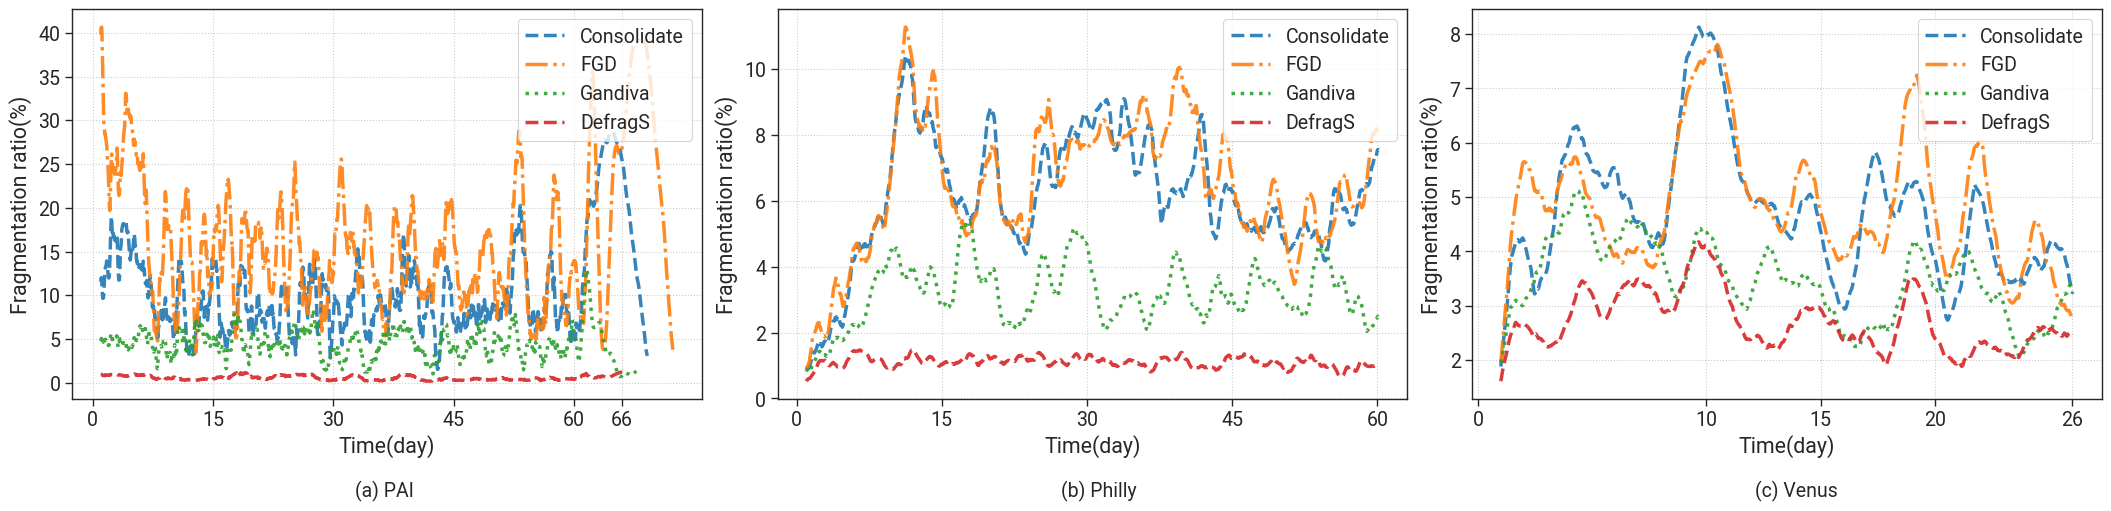

In [61]:
# fragmentation ration & gpu utilization

data_name = ['PAI', 'Philly',  'Venus']
xticks = [[0, 15, 30, 45, 60, 66], [0, 15, 30, 45, 60], [0, 10, 15, 20, 26]]
schedulers = ["dynamic_consolidate", "dynamic_FGD", "gandiva_dynamic", "defragS_dynamic"]
labels = ['Consolidate', 'FGD', 'Gandiva', 'DefragS']	
log_dir = '../log/test'

albation = False
# 消融实验中对比碎片率
# albation = True
# schedulers = ["fifo_consolidate",  "dynamic_consolidate", "defragS_dynamic_noDefrag", "defragS_dynamic"]
# labels = ["Base", 'S','S+D', 'S+P+D', ]
# log_dir = '../log/ablation'

window_size = 60 * 24
data_type = 'fragmentation_ratio' #  gpu_utilization

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(21, 5))
linestyles = ["--", "-.", ":", "--"]
ax_number = ['a', 'b', 'c']

for i, data in enumerate(data_name):
	ax = axes[i]
	for j, scheduler in enumerate(schedulers):
		if data == 'PAI':
			df = pd.read_csv(log_dir+f'/ali20/ali20_{scheduler}/all/{scheduler}_all_seq.csv')
		elif data == 'Philly':
			df = pd.read_csv(log_dir+f'/Philly_mutation/Philly_{scheduler}/all/{scheduler}_all_seq.csv')
		elif data == 'Venus':
			df = pd.read_csv(log_dir+f'/Venus_Sept/Venus_Sept_{scheduler}/all/{scheduler}_all_seq.csv')
		y = df[data_type]*100
		y_mean = y.rolling(window=window_size).mean()
		ax.plot(range(len(y_mean)), y_mean, linestyles[j], alpha=0.9, label=labels[j])
	
	ax.set_xlabel(f"Time(day)")
	if data_type == 'gpu_utilization':
		ax.set_ylabel(f"GPU Utilization(%)")
		ax.legend(loc="lower right")
	elif data_type == 'fragmentation_ratio':
		ax.set_ylabel(f"Fragmentation ratio(%)")
		ax.legend(loc="upper right")

	ax.set_xticks([tick * window_size for tick in xticks[i]])
	ax.set_xticklabels(xticks[i])
	ax.grid(linestyle=":")
	ax.text(0.45, -0.25, f"({ax_number[i]}) {data}", transform=ax.transAxes, size=14)

save = True
if save:
	if albation:
		fig.savefig(f"../figures/experiment3_Ablation_fragmentation.pdf", bbox_inches="tight", dpi=600,)
		
	if data_type == 'gpu_utilization':
		fig.savefig(f"../figures/experiment1_gpu_utilization.pdf", bbox_inches="tight", dpi=600,)
	elif data_type == 'fragmentation_ratio':
		fig.savefig(f"../figures/experiment1_fragmenation_ration.pdf", bbox_inches="tight", dpi=600,)

/tmp/ipykernel_85042/789510993.py:90: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.1)


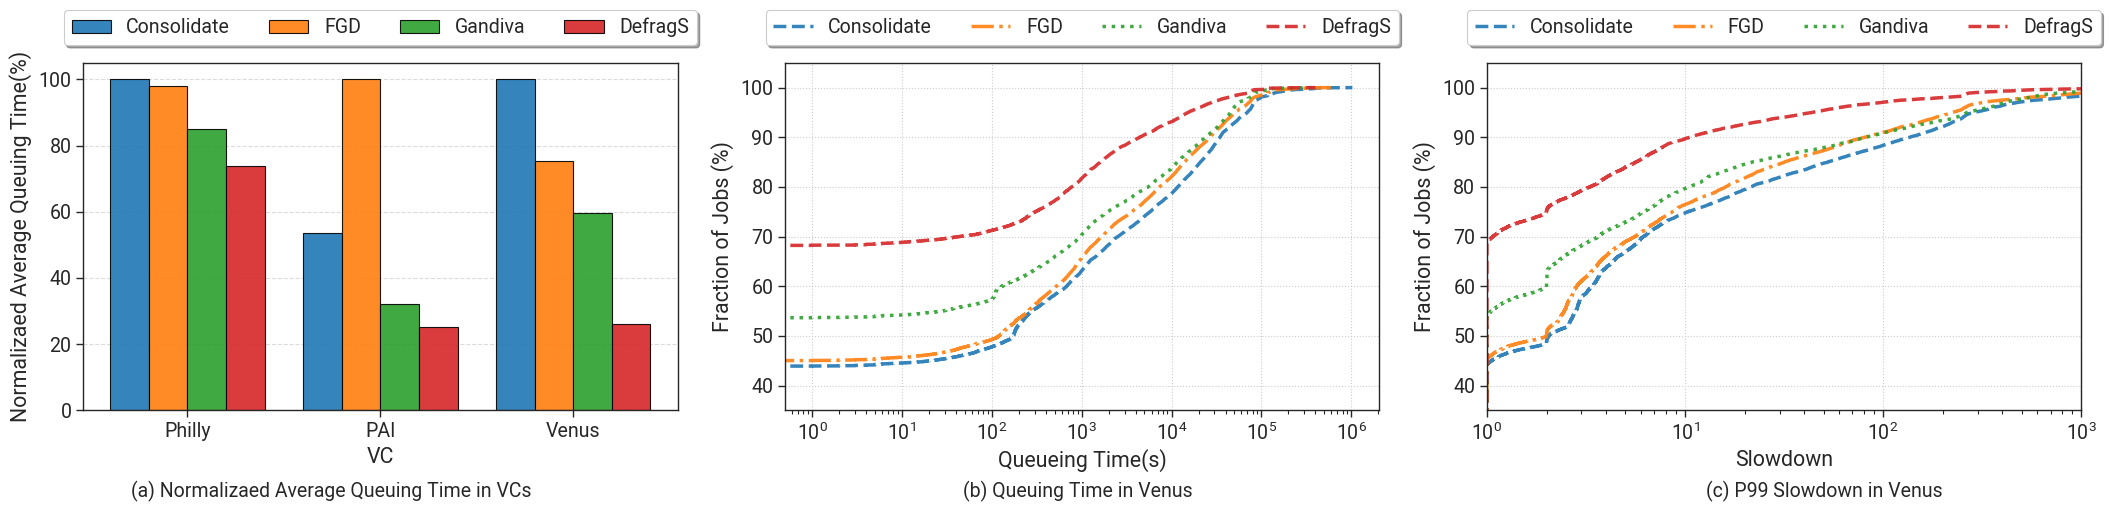

In [52]:
data_name = ['Philly', 'PAI', 'Venus']
schedulers = ["dynamic_consolidate", "dynamic_FGD", "gandiva_dynamic", "defragS_dynamic"]
labels = ['Consolidate', 'FGD', 'Gandiva', 'DefragS']

log_dir = '../log/test'

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(21, 5))
x = np.arange(len(data_name))
width = 0.2 

shcedulers_data = []
improvement_ratios = []
venus_dfs = []
for i, data in enumerate(data_name):
	que_ls = []
	for j, scheduler in enumerate(schedulers):
		if data == 'PAI':
			df = pd.read_csv(log_dir+f'/ali20/ali20_{scheduler}/que_avg.csv')
		elif data == 'Philly':
			df = pd.read_csv(log_dir+f'/Philly_mutation/Philly_{scheduler}/que_avg.csv')
		elif data == 'Venus':
			df = pd.read_csv(log_dir+f'/Venus_Sept/Venus_Sept_{scheduler}/que_avg.csv')
			venus_dfs.append(pd.read_csv(log_dir+f'/Venus_Sept/Venus_Sept_{scheduler}/all/{scheduler}_all_log.csv'))
		que_ls.append(df.iloc[len(df)-1, 1])

	# calculate improvement ratio that DefragS is better than others
	defragS_value = que_ls[-1]
	others_min = min(que_ls[:-1])
	improvement = (others_min - defragS_value) / others_min * 100 
	improvement_ratios.append(improvement)

	# Normalize the queuing time
	que_ls = np.array(que_ls) / max(que_ls) * 100
	shcedulers_data.append(que_ls)

# 1. Draw Queue of different schedulers in each VC
scheduler_data = np.array(shcedulers_data).T
for i in range(len(schedulers)):
	ax1.bar(x + width * (i - 1.5), scheduler_data[i], width, alpha=0.9,linewidth=0.8,edgecolor="k", label=labels[i])
# for idx, ratio in enumerate(improvement_ratios):
# 	plt.rcParams["font.family"] = "DejaVu Sans"
# 	defragS_height = scheduler_data[-1][idx]
# 	ax1.text(x[idx] + width*2+0.02, defragS_height + 2, f'\u2193{ratio:.1f}%', ha='center', va='bottom', size=13)

test_y_offset = -0.25
ax1.set_xlabel('VC')
ax1.set_xticks(x)
ax1.set_xticklabels(data_name)
ax1.set_ylabel('Normalizaed Average Queuing Time(%)')
ax1.set_ylim(0, 105)
ax1.legend(loc="upper center",bbox_to_anchor=(0.5, 1.18),ncol=4,fancybox=True,shadow=True,)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.text(-1.1, test_y_offset, '(a) Normalizaed Average Queuing Time in VCs', transform=ax2.transAxes, size=14)

# 2. Draw P95 Queue CDF of Venus
linestyles = ["--", "-.", ":", "--"]
for idx, scheduler in enumerate(schedulers):
	y = venus_dfs[idx]['queue']
	sorted_y = np.sort(y)
	cdf = np.arange(1, len(sorted_y) + 1) / len(sorted_y) * 100
	ax2.plot(sorted_y, cdf, linestyles[idx], alpha=0.9, label=labels[idx])

	big_y = venus_dfs[idx]['slowdown']
	sorted_BigY = np.sort(big_y)
	cdf = np.arange(1, len(sorted_BigY) + 1) / len(sorted_BigY) * 100
	ax3.plot(sorted_BigY, cdf, linestyles[idx], alpha=0.9, label=labels[idx])

ax2.set_xlabel("Queueing Time(s)")
ax2.set_xscale("log")
ax2.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
ax2.set_ylabel("Fraction of Jobs (%)")
ax2.set_ylim(35, 105)
ax2.legend(loc="upper center",bbox_to_anchor=(0.5, 1.18),ncol=4,fancybox=True,shadow=True,)
ax2.grid(linestyle=":")
ax2.text(0.3, test_y_offset, "(b) Queuing Time in Venus", transform=ax2.transAxes, size=14)


x_min = np.min(sorted_BigY)
x_max = np.percentile(sorted_BigY, 99)  # 选择中位数作为最大范围
ax3.set_xlim(x_min, x_max)  # 设置 x 轴范围
ax3.set_xlabel("Slowdown")
ax3.set_xscale("log")
ax3.set_xticks([1e0, 1e1, 1e2, 1e3])
ax3.set_ylabel("Fraction of Jobs (%)")
ax3.set_ylim(35, 105)
ax3.legend(loc="upper center",bbox_to_anchor=(0.5, 1.18),ncol=4,fancybox=True,shadow=True,)
ax3.grid(linestyle=":")
ax3.text(1.55, test_y_offset, "(c) P99 Slowdown in Venus", transform=ax2.transAxes, size=14)

plt.subplots_adjust(wspace=0.1) 

save = True
if save:
	fig.savefig(f"../figures/experiment2_QueuingTime_analysis.pdf", bbox_inches="tight", dpi=600,)

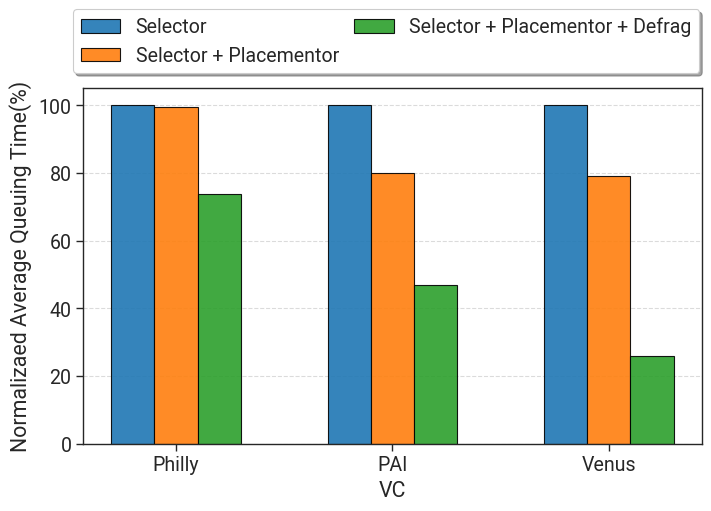

In [111]:
# Ablation Study
data_name = ['Philly', 'PAI', 'Venus']
schedulers = ["dynamic_consolidate", "defragS_dynamic_noDefrag", "defragS_dynamic"]
labels = ['Selector', 'Selector + Placementor', 'Selector + Placementor + Defrag']
log_dir = '../log/ablation'

fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(7, 5))
x = np.arange(len(data_name))
width = 0.2 

shcedulers_data = []
for i, data in enumerate(data_name):
	que_ls = []
	for j, scheduler in enumerate(schedulers):
		if data == 'PAI':
			df = pd.read_csv(log_dir+f'/ali20/ali20_{scheduler}/que_avg.csv')
		elif data == 'Philly':
			df = pd.read_csv(log_dir+f'/Philly_mutation/Philly_{scheduler}/que_avg.csv')
		elif data == 'Venus':
			df = pd.read_csv(log_dir+f'/Venus_Sept/Venus_Sept_{scheduler}/que_avg.csv')
		que_ls.append(df.iloc[len(df)-1, 1])

	# Normalize the queuing time
	que_ls = np.array(que_ls) / max(que_ls) * 100
	shcedulers_data.append(que_ls)

# 1. Draw Queue of different schedulers in each VC
scheduler_data = np.array(shcedulers_data).T
for i in range(len(schedulers)):
	ax1.bar(x + width * (i - 1), scheduler_data[i], width, alpha=0.9,linewidth=0.8,edgecolor="k", label=labels[i])

test_y_offset = -0.25
ax1.set_xlabel('VC')
ax1.set_xticks(x)
ax1.set_xticklabels(data_name)
ax1.set_ylabel('Normalizaed Average Queuing Time(%)')
ax1.set_ylim(0, 105)
ax1.legend(loc="upper center",bbox_to_anchor=(0.49, 1.25), ncol=2, columnspacing=0.8, fancybox=True, shadow=True,)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

save = True
if save:
	fig.savefig(f"../figures/experiment3_Ablation.pdf", bbox_inches="tight", dpi=600,)


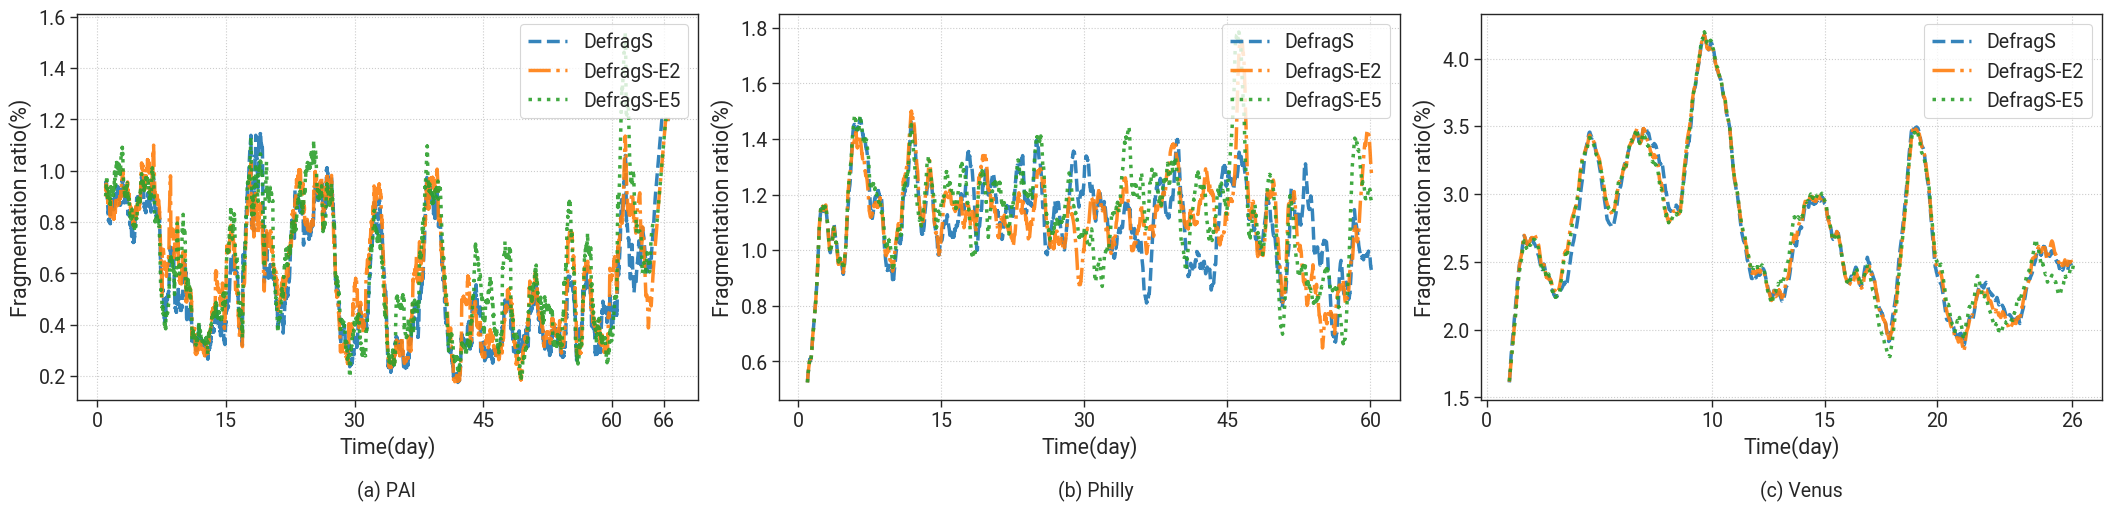

In [96]:
# 实验4：鲁棒性，duration不可只知

data_name = ['PAI', 'Philly',  'Venus']
xticks = [[0, 15, 30, 45, 60, 66], [0, 15, 30, 45, 60], [0, 10, 15, 20, 26]]
scheduler = "defragS_dynamic"

log_dirs = ["../log/test", "../log/noDuration_2", "../log/noDuration_5"]
labels = ['DefragS', "DefragS-E2", "DefragS-E5"]


window_size = 60 * 24
data_type = 'fragmentation_ratio' #  gpu_utilization

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(21, 5))
linestyles = ["--", "-.", ":", "--"]
ax_number = ['a', 'b', 'c']

for i, data in enumerate(data_name):
	ax = axes[i]
	for j, log_dir in enumerate(log_dirs):
		if data == 'PAI':
			df = pd.read_csv(log_dir+f'/ali20/ali20_{scheduler}/all/{scheduler}_all_seq.csv')
		elif data == 'Philly':
			df = pd.read_csv(log_dir+f'/Philly_mutation/Philly_{scheduler}/all/{scheduler}_all_seq.csv')
		elif data == 'Venus':
			df = pd.read_csv(log_dir+f'/Venus_Sept/Venus_Sept_{scheduler}/all/{scheduler}_all_seq.csv')
		y = df[data_type]*100
		y_mean = y.rolling(window=window_size).mean()
		ax.plot(range(len(y_mean)), y_mean, linestyles[j], alpha=0.9, label=labels[j])
	
	ax.set_xlabel(f"Time(day)")
	ax.set_ylabel(f"Fragmentation ratio(%)")
	ax.legend(loc="upper right")

	ax.set_xticks([tick * window_size for tick in xticks[i]])
	ax.set_xticklabels(xticks[i])
	ax.grid(linestyle=":")
	ax.text(0.45, -0.25, f"({ax_number[i]}) {data}", transform=ax.transAxes, size=14)

save = True
if save:
	fig.savefig(f"../figures/experiment4_noDuration_fragmentation_ratio.pdf", bbox_inches="tight", dpi=600,)

PAI [ 99.05812702  99.35414424 100.        ]
Philly [ 94.09802852  99.18335541 100.        ]
Venus [ 99.31529182 100.          99.86957939]


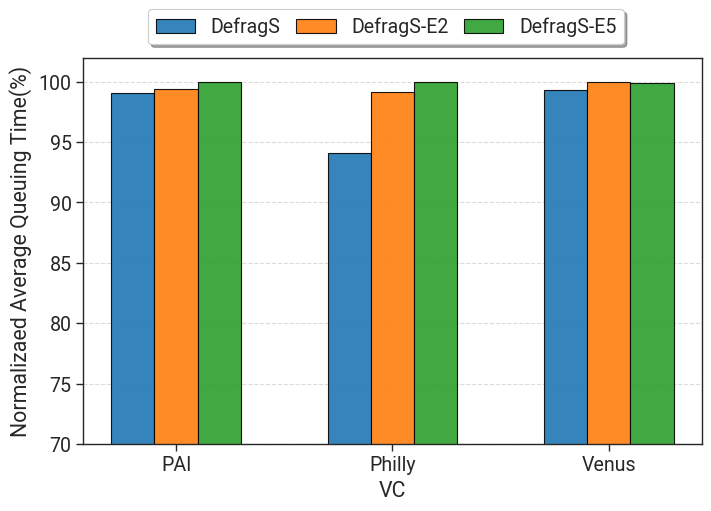

In [105]:
# 续实验4：鲁棒性，duration不可只知 画queuing time
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(7, 5))
x = np.arange(len(data_name))
width = 0.2

shcedulers_data = []
for i, data in enumerate(data_name):
	que_ls = []
	for j in range(len(log_dirs)):
		if data == 'PAI':
			df = pd.read_csv(log_dirs[j]+f'/ali20/ali20_{scheduler}/que_avg.csv')
		elif data == 'Philly':
			df = pd.read_csv(log_dirs[j]+f'/Philly_mutation/Philly_{scheduler}/que_avg.csv')
		elif data == 'Venus':
			df = pd.read_csv(log_dirs[j]+f'/Venus_Sept/Venus_Sept_{scheduler}/que_avg.csv')
		que_ls.append(df.iloc[len(df)-1, 1])

	# Normalize the queuing time
	que_ls = np.array(que_ls) / max(que_ls) * 100
	print(data, que_ls)
	shcedulers_data.append(que_ls)

scheduler_data = np.array(shcedulers_data).T
for i in range(len(log_dirs)):
	ax1.bar(x + width * (i-1), scheduler_data[i], width, alpha=0.9,linewidth=0.8,edgecolor="k", label=labels[i])


ax1.set_xlabel('VC')
ax1.set_xticks(x)
ax1.set_xticklabels(data_name)
ax1.set_ylabel('Normalizaed Average Queuing Time(%)')
ax1.set_ylim(70, 102)
ax1.legend(loc="upper center",bbox_to_anchor=(0.49, 1.15), ncol=len(log_dirs), columnspacing=0.8, fancybox=True, shadow=True,)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

save = True
if save:
	fig.savefig(f"../figures/experiment4_noDuration_queuing_time.pdf", bbox_inches="tight", dpi=600,)